# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import pickle
from pprint import pprint as pp

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
# cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
# X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train_5000 = pickle.load(open("X_train_5000", "rb"))
y_train_5000 = pickle.load(open("y_train_5000", "rb"))
X_test_500 = pickle.load(open("X_test_500", "rb"))
y_test_500 = pickle.load(open("y_test_500", "rb"))

In [4]:
num_training = 5000
mask = range(num_training)
X_train = X_train_5000[mask]
y_train = y_train_5000[mask]

num_test = 500
mask = range(num_test)
X_test = X_test_500[mask]
y_test = y_test_500[mask]

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (5000, 32, 32, 3)
Training labels shape:  (5000,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)


In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

# num_training = 49000
# num_validation = 1000
# num_test = 1000
# num_dev = 500

num_training = 4900
num_validation = 100
num_test = 100
num_dev = 5

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (4900, 32, 32, 3)
Train labels shape:  (4900,)
Validation data shape:  (100, 32, 32, 3)
Validation labels shape:  (100,)
Test data shape:  (100, 32, 32, 3)
Test labels shape:  (100,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (4900, 3072)
Validation data shape:  (100, 3072)
Test data shape:  (100, 3072)
dev data shape:  (5, 3072)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
# plt.figure(figsize=(2,2))
# plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
# plt.show()

[ 131.39897959  136.3122449   132.67163265  130.74959184  135.70265306
  132.03673469  131.63612245  136.45979592  132.66346939  132.68367347]


In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(4900, 3073) (100, 3073) (100, 3073) (5, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """

'\nStructured SVM loss function, naive implementation (with loops).\n\nInputs have dimension D, there are C classes, and we operate on minibatches\nof N examples.\n\nInputs:\n- W: A numpy array of shape (D, C) containing weights.\n- X: A numpy array of shape (N, D) containing a minibatch of data.\n- y: A numpy array of shape (N,) containing training labels; y[i] = c means\n  that X[i] has label c, where 0 <= c < C.\n- reg: (float) regularization strength\n\nReturns a tuple of:\n- loss as single float\n- gradient with respect to weights W; an array of same shape as W\n'

The SVM loss is set up so that the SVM “wants” the correct class for each image to a have a score higher than the incorrect classes by some fixed margin $\Delta$
$L_i = \sum_{j\neq y_i} \max(0, w_j^T x_i - w_{y_i}^T x_i + \Delta)$ where $x_i$ is labeled as $y_i$,
<br /> $x_i$: means ith image, 
<br /> $w_j$: means jth class model weight,
<br /> $y_i$ means the label of $x_i$,
<br /> $x_i$, $w_j$ are a vector in the equation.
<br />
$w_j^T x_i ({j\neq y_i})$ : the score of label = 0 (wrong class score)
<br />
$w_{y_i}^T x_i $ : the score of label = 1 (correct class score)
<br /><br />
Define a loss function that quantifies our "unhappiness" with the scores "across" the training data.
<br />
ps: This is the multi-classify SVM, **we compare the right prediction score across all wrong prediction scores**,
<br /><br />
if right prediction has highest score: means this pic is happer with the model, (predict wrong score - predict correct score < 0) then loss = 0 (filter into 0)
<br />
if wrong prediction score is higher than right prediction score, means this pic is unhapper with the model, (predict wrong score - predict correct score < 0) then loss < 0
<br /><br />
the multi-classify SVM loss add up all the loss value across different classes, then object is to maximize this loss value to make all data less unhappy to this multi-classify SVM.

<--img src="SVM_example.png"-->

this is the gradient only with respect to the row of WW that corresponds to the correct class
<br/> $\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) \right) x_i$
<br/> For the other rows where $j\neq y_i$ the gradient
<br/> $\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) x_i$
<br/> - $1$ is the indicator function that is one if the condition inside is true or zero otherwise. 
<br/> - you’d simply count the number of classes that didn’t meet the desired margin (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient.

In [15]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 10.279916


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [93]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 38.992449 analytic: 38.992449, relative error: 1.343004e-13
numerical: -26.345918 analytic: -26.345918, relative error: 3.489211e-13
numerical: 0.279020 analytic: 0.279020, relative error: 9.262353e-11
numerical: 12.758367 analytic: 12.758367, relative error: 2.866204e-12
numerical: 3.243878 analytic: 3.243878, relative error: 6.467327e-12
numerical: -167.678694 analytic: -167.678694, relative error: 5.941011e-14
numerical: 7.985102 analytic: 7.985102, relative error: 8.933392e-13
numerical: 12.157959 analytic: 12.157959, relative error: 1.621855e-12
numerical: 92.655184 analytic: 92.655184, relative error: 2.615786e-13
numerical: -136.482939 analytic: -136.482939, relative error: 1.468118e-14
numerical: -122.671562 analytic: -122.671562, relative error: 1.019434e-14
numerical: -2.492299 analytic: -2.492299, relative error: 1.651415e-12
numerical: -104.681573 analytic: -104.681573, relative error: 6.088529e-14
numerical: -140.784374 analytic: -140.784374, relative error: 4.0

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 1.027992e+01 computed in 0.011736s
Vectorized loss: 1.027992e+01 computed in 0.985785s
difference: -0.000000


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()

_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.011858s
Vectorized loss and gradient: computed in 0.008966s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)

toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 793.703161
iteration 100 / 1500: loss 288.783137
iteration 200 / 1500: loss 108.623285
iteration 300 / 1500: loss 42.810876
iteration 400 / 1500: loss 18.886833
iteration 500 / 1500: loss 9.920820
iteration 600 / 1500: loss 6.808303
iteration 700 / 1500: loss 5.132551
iteration 800 / 1500: loss 5.289783
iteration 900 / 1500: loss 4.974679
iteration 1000 / 1500: loss 4.644925
iteration 1100 / 1500: loss 5.183375
iteration 1200 / 1500: loss 5.074583
iteration 1300 / 1500: loss 5.089440
iteration 1400 / 1500: loss 4.386833
That took 183.176977s


In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.408163
validation accuracy: 0.360000


In [25]:
from cs231n.classifiers import LinearSVM
from numpy.random import uniform

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.

learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# don't use grid search, as one paramenter may more important than another
# learning_rates = np.logspace(-7, -6, num=5, endpoint=False, base=10.0)
# regularization_strengths = np.logspace(4, 5, num = 5, endpoint=False, base=10.0)
# for lr in learning_rates:
#     for rs in regularization_strengths:
        
for count in range(20):
        lr = 10**uniform(-7,-5)
        rs = 10**uniform(4,6)
        print lr, rs
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs,num_iters=500, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        train_ac = np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_ac, )
        
        y_val_pred = svm.predict(X_val)
        val_ac = np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_ac, )
        
        if(val_ac > best_val):
            best_val = val_ac
            best_svm = svm
        
        results[(lr,rs)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

1.00056973034e-06 152217.737198
iteration 0 / 500: loss 2383.050601
iteration 100 / 500: loss 6.804151
iteration 200 / 500: loss 8.412474
iteration 300 / 500: loss 7.074298
iteration 400 / 500: loss 6.917116
training accuracy: 0.258367
validation accuracy: 0.180000
1.02953752819e-06 227300.183008
iteration 0 / 500: loss 3495.327074
iteration 100 / 500: loss 8.951728
iteration 200 / 500: loss 9.253348
iteration 300 / 500: loss 7.516224
iteration 400 / 500: loss 7.851966
training accuracy: 0.244898
validation accuracy: 0.190000
6.70712066814e-07 185097.845348
iteration 0 / 500: loss 2869.552437
iteration 100 / 500: loss 6.476716
iteration 200 / 500: loss 6.754436
iteration 300 / 500: loss 6.661729
iteration 400 / 500: loss 5.815179
training accuracy: 0.281837
validation accuracy: 0.290000
4.92397802789e-06 62811.9889768
iteration 0 / 500: loss 990.708501
iteration 100 / 500: loss 28.684622
iteration 200 / 500: loss 23.960753
iteration 300 / 500: loss 19.491248
iteration 400 / 500: loss 2

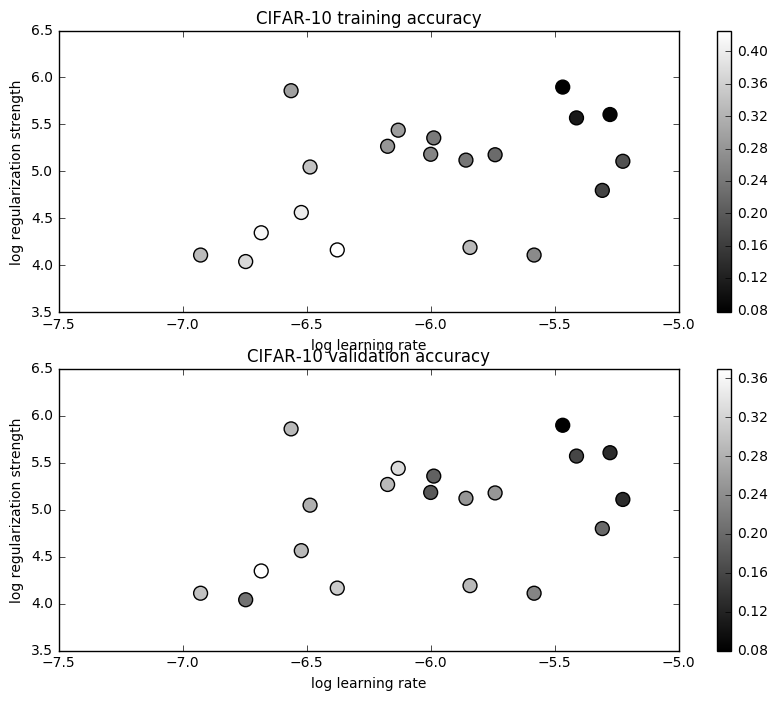

In [26]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.450000


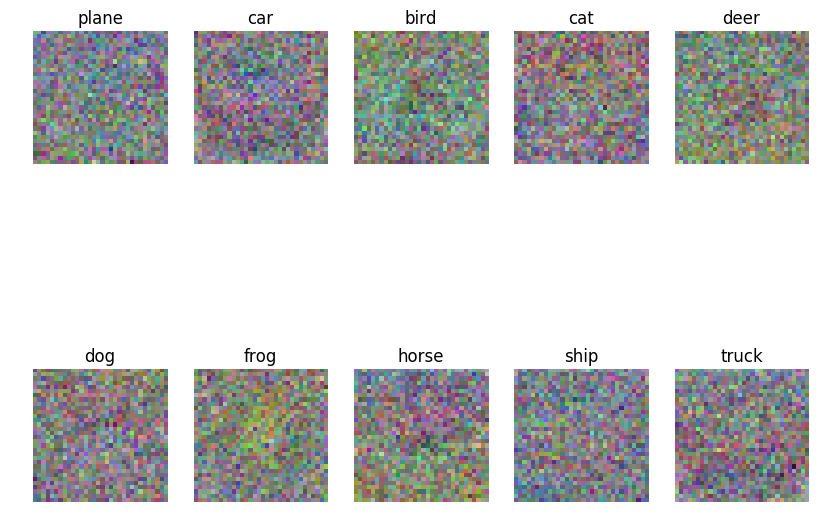

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*